In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
!pip install scikit-optimize
import skopt

In [2]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
from fun_objective_loop_manywalls_random import objective_random_storms
#from fun_objective_loop import constraint1
#from fun_objective_loop import constraint2
#from fun_objective_loop import constraint3

#input_name = sys.argv[1]
output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

def objective3(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    if we > ws:
        x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    return total_cost_new

def objective4(x_input):
    x = np.ones(163)*x_input
    print(x_input)
    
    
    num_iter = np.random.randint(10)
    num_iter = 1
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=num_iter)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

def damage2(h):
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    damage_cost = total_cost_new-wall_cost
    return damage_cost, wall_cost, n_cost_direct_sum_div

def objective5(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    wl = x_input[1]
    we = int(min(ws+wl,162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print('--------')
    print(x_input)
    print([ws,we,wh])
    #print(x)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new)
    return total_cost_new

def objective_r(x_input, num_iter = 1):
    x = np.ones(163)*x_input
    print(x_input)
    
    
    #num_iter = np.random.randint(10)
    #num_iter = 1
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective_random_storms(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=num_iter)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]




C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\pdine\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
 

In [140]:
obj4_101 = np.zeros(101)
for i, x in enumerate(np.linspace(0,5,101)):
    obj4_101[i] = objective4(x)

0.0
0
5.56506992569983
0.05
0
5.486408940499073
0.1
0
5.45871765351906
0.15000000000000002
0
5.397853961052378
0.2
0
5.317234976466337
0.25
0
5.254975083883782
0.30000000000000004
0
5.121530221714931
0.35000000000000003
0
4.93734405837719
0.4
0
4.941760486753782
0.45
0
4.902988602858221
0.5
0
4.887710706031441
0.55
0
4.887542310158345
0.6000000000000001
0
4.857071522053774
0.65
0
4.854253769946199
0.7000000000000001
0
4.9551839975351895
0.75
0
4.969479064001318
0.8
0
5.0900784640328895
0.8500000000000001
0
4.968830172029828
0.9
0
5.024839794015937
0.9500000000000001
0
5.056031794212155
1.0
0
4.836656042531507
1.05
0
4.686315310618354
1.1
0
4.724671159881795
1.1500000000000001
0
4.744166772220007
1.2000000000000002
0
4.519428878477349
1.25
0
4.426102462702822
1.3
0
4.339512116226052
1.35
0
4.049733182524352
1.4000000000000001
0
3.8097607465910417
1.4500000000000002
0
3.7279234386438898
1.5
0
3.790831757862168
1.55
0
3.8799511536340443
1.6
0
3.8756181956422604
1.6500000000000001
0
3.6994

In [143]:
obj4_inter = lambda x : np.interp(x,np.linspace(0,5,101),obj4_101)

In [147]:
res2 = skopt.gp_minimize(objective2,
                        [(0.,5.),(0.,5.),(0.,5.),(0.,5.),(0.,5.),(0.,5.),(0.,5.),(0.,5.)],
                       n_calls = 250)

0
6.249744483477055
0
2.8381742245170942
0
4.992767380200277
0
4.576792224473382
0
6.241131778498818
0
5.931866883682977
0
3.341424632240694
0
4.4233563549746435
0
5.715793803291718
0
2.329589316019249
0
2.5527866234600203
0
5.577046577374324
0
2.8051584323385224
0
2.171843860314187
0
4.807780825814133
0
2.1101243388639706
0
2.766989907045901
0
2.4764624038300305
0
3.857523950964575
0
2.171732996073983
0
2.049113679362495
0
2.296901243815901
0
5.0389931805996975
0
2.1442721687472117
0
2.4739070625162203
0
5.259237201416267
0
2.0749120256269595
0
2.39527443045073
0
2.1382323259025275
0
2.1721189822918063
0
3.753613715100681
0
1.8912694711744993
0
2.4094411180488304
0
2.8302533322647476
0
2.998431971239149
0
2.9803827997169234
0
2.299656019038901
0
2.071188192412273
0
3.359833552016211
0
1.9842410461206088
0
2.5209558906796463
0
2.256060219380991
0
2.2586602454004994
0
1.920451288135813
0
2.076137245461122
0
2.187561638811899
0
1.9785490960980896
0
4.7261809613636245
0
2.015445602871079


In [150]:
#res2.models[0].predict()

ValueError: Expected 2D array, got 1D array instead:
array=[0.         0.05050505 0.1010101  0.15151515 0.2020202  0.25252525
 0.3030303  0.35353535 0.4040404  0.45454545 0.50505051 0.55555556
 0.60606061 0.65656566 0.70707071 0.75757576 0.80808081 0.85858586
 0.90909091 0.95959596 1.01010101 1.06060606 1.11111111 1.16161616
 1.21212121 1.26262626 1.31313131 1.36363636 1.41414141 1.46464646
 1.51515152 1.56565657 1.61616162 1.66666667 1.71717172 1.76767677
 1.81818182 1.86868687 1.91919192 1.96969697 2.02020202 2.07070707
 2.12121212 2.17171717 2.22222222 2.27272727 2.32323232 2.37373737
 2.42424242 2.47474747 2.52525253 2.57575758 2.62626263 2.67676768
 2.72727273 2.77777778 2.82828283 2.87878788 2.92929293 2.97979798
 3.03030303 3.08080808 3.13131313 3.18181818 3.23232323 3.28282828
 3.33333333 3.38383838 3.43434343 3.48484848 3.53535354 3.58585859
 3.63636364 3.68686869 3.73737374 3.78787879 3.83838384 3.88888889
 3.93939394 3.98989899 4.04040404 4.09090909 4.14141414 4.19191919
 4.24242424 4.29292929 4.34343434 4.39393939 4.44444444 4.49494949
 4.54545455 4.5959596  4.64646465 4.6969697  4.74747475 4.7979798
 4.84848485 4.8989899  4.94949495 5.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

AssertionError: Space dimension must be 1

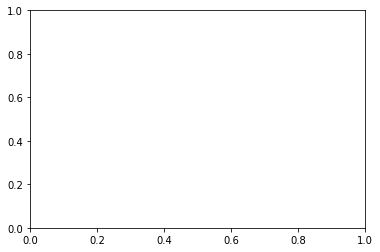

In [148]:
for n_iter in range(20):
    # Plot true function.
    plt.figure()

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res2, n_calls=n_iter,
    #                           objective=obj4_inter,
                               noise_level=0,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False,
                               n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

In [41]:
print(res.x)
print(res.fun)
print(res.models)

[4.8809147271020885, 2.7690065306572977, 3.501871316761767, 1.7377130814565833, 1.9909733475426354, 1.9819490542392124, 2.1295326889423554, 1.6016765814574887]
2036028901.1027477
[GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=964754802), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=964754802), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kern

In [46]:
x_vals_array = np.array(res.x_iters)
print(x_vals_array.shape)

(250, 8)


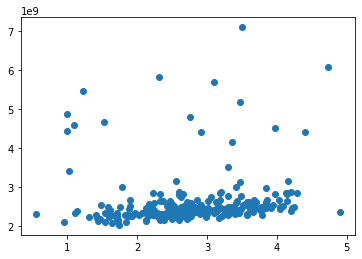

In [60]:
plt.scatter(x_vals_array[:,3],res.func_vals)

In [28]:
skopt.gp_minimize(objective5,[(0,163),(0,163),(0.0,5.0)])

--------
[116, 38, 4.715890128136785]
[116, 154, 4.715890128136785]
0
6161793428.155461
--------
[123, 30, 1.0324853595714736]
[123, 153, 1.0324853595714736]
0
5490322002.626556
--------
[79, 46, 0.5280148430552607]
[79, 125, 0.5280148430552607]
0
5640717483.098128
--------
[149, 71, 4.463912557430495]
[149, 162, 4.463912557430495]
0
5807874875.708273
--------
[157, 131, 4.11551294788967]
[157, 162, 4.11551294788967]
0
5655426628.757284
--------
[70, 90, 1.0148011161712243]
[70, 160, 1.0148011161712243]
0
5115216041.428655
--------
[147, 151, 4.289988745658737]
[147, 162, 4.289988745658737]
0
5835763253.96409
--------
[127, 75, 0.0839616978151997]
[127, 162, 0.0839616978151997]
0
5541500199.004737
--------
[44, 147, 1.3352930482676142]
[44, 162, 1.3352930482676142]
0
5227935120.369131
--------
[26, 57, 2.84328378953008]
[26, 83, 2.84328378953008]
0
6338847037.746229
--------
[70, 90, 1.0148012309138943]
[70, 160, 1.0148012309138943]
0
5115216089.105917


C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--------
[70, 90, 1.014801109654109]
[70, 160, 1.014801109654109]
0
5115216038.720698
--------
[70, 90, 1.5082999129710182]
[70, 160, 1.5082999129710182]
0
5333483043.0149765
--------
[70, 90, 1.5892360099671234]
[70, 160, 1.5892360099671234]
0
5398408333.382565
--------
[70, 90, 0.1645551172862268]
[70, 160, 0.1645551172862268]
0
5408413396.359295
--------
[70, 90, 1.0696489420746977]
[70, 160, 1.0696489420746977]
0
5139413962.322458
--------
[72, 90, 1.1181041336662785]
[72, 162, 1.1181041336662785]
0
5012089387.447827
--------
[71, 90, 0.5624632483331603]
[71, 161, 0.5624632483331603]
0
5045930877.205095
--------
[81, 90, 1.152958799227639]
[81, 162, 1.152958799227639]
0
5033510985.266023
--------
[77, 90, 0.43463012243361404]
[77, 162, 0.43463012243361404]
0
5034417158.049694
--------
[68, 90, 0.49537769625369177]
[68, 158, 0.49537769625369177]
0
5289279602.11479
--------
[74, 90, 0.8320273991941645]
[74, 162, 0.8320273991941645]
0
4869036305.966594
--------
[65, 90, 0.280719095588

KeyboardInterrupt: 

In [30]:
skopt.gp_minimize(objective5,[(0,163),(0,163),(0.0,5.0)])

--------
[50, 134, 3.149338057493569]
[50, 162, 3.149338057493569]
0
6113084108.038067
--------
[33, 145, 1.7110405509719198]
[33, 162, 1.7110405509719198]
0
5424911840.082595
--------
[133, 73, 1.0868711467955314]
[133, 162, 1.0868711467955314]
0
5386342160.333633
--------
[127, 80, 4.330957359069659]
[127, 162, 4.330957359069659]
0
5638337867.38897
--------
[136, 104, 1.16849360755484]
[136, 162, 1.16849360755484]
0
5573660979.133811
--------
[115, 110, 3.59391643330681]
[115, 162, 3.59391643330681]
0
5544862260.808804
--------
[120, 85, 3.3221340234443026]
[120, 162, 3.3221340234443026]
0
5477636310.306984
--------
[54, 96, 2.319160077432529]
[54, 150, 2.319160077432529]
0
6061748631.784087
--------
[19, 156, 3.696232424256035]
[19, 162, 3.696232424256035]
0
6899429934.446518
--------
[28, 116, 4.560381823522046]
[28, 144, 4.560381823522046]
0
7582466767.43894
--------
[120, 92, 4.633417773952875]
[120, 162, 4.633417773952875]
0
5748666073.213101
--------
[127, 82, 2.644985923051963

--------
[132, 96, 1.9545393045565216]
[132, 162, 1.9545393045565216]
0
5386272501.188297
--------
[133, 142, 1.9506165113417375]
[133, 162, 1.9506165113417375]
0
5509611407.285772
--------
[132, 100, 1.9522318820755078]
[132, 162, 1.9522318820755078]
0
5385931842.562891
--------
[133, 86, 1.9482243172204834]
[133, 162, 1.9482243172204834]
0
5509270005.780197
--------
[132, 62, 1.9498695741932748]
[132, 162, 1.9498695741932748]
0
5385583080.8763895
--------
[133, 94, 1.9457769690485291]
[133, 162, 1.9457769690485291]
0
5508920732.975306
--------
[132, 107, 1.9476353328043094]
[132, 162, 1.9476353328043094]
0
5385253226.414688
--------
[133, 89, 1.943189424779186]
[133, 162, 1.943189424779186]
0
5508551452.112415


          fun: 5273920296.819723
    func_vals: array([6.11308411e+09, 5.42491184e+09, 5.38634216e+09, 5.63833787e+09,
       5.57366098e+09, 5.54486226e+09, 5.47763631e+09, 6.06174863e+09,
       6.89942993e+09, 7.58246677e+09, 5.74866607e+09, 5.34794278e+09,
       5.32969737e+09, 5.38224580e+09, 5.32041636e+09, 5.37825700e+09,
       5.27392030e+09, 5.30031609e+09, 5.31850958e+09, 5.34568119e+09,
       5.42792637e+09, 5.41992875e+09, 5.36715225e+09, 5.36616469e+09,
       5.36198076e+09, 5.35959839e+09, 5.34839899e+09, 5.34660079e+09,
       5.37897190e+09, 5.34923485e+09, 5.34392608e+09, 5.34260583e+09,
       5.34138224e+09, 5.34020691e+09, 5.33914966e+09, 5.33812605e+09,
       5.33714339e+09, 5.33621245e+09, 5.33531177e+09, 5.33444536e+09,
       5.33360047e+09, 5.40025221e+09, 5.39970408e+09, 5.41252766e+09,
       5.39897574e+09, 5.39835231e+09, 5.39782154e+09, 5.39729820e+09,
       5.39677818e+09, 5.39625924e+09, 5.39574029e+09, 5.39522616e+09,
       5.39470593e+09, 5.3942

In [122]:
res4 = skopt.gp_minimize(objective4,
                         [(0.0,5.0)],
                         acq_func="EI",
                         n_calls=30,
                         n_random_starts=5,
                         noise=0.01)

[4.518745607503323]
0
3.624737094034192
[3.8148717328546784]
0
3.0601207237910835
[1.2150748090027665]
0
4.492667132947355
[4.256029084457726]
0
3.4139975638606375
[0.45805959428081416]
0
4.8950343440127035
[3.224172734084765]
0
2.5862882140134054
[2.8936686223093417]
0
2.3367257110155664
[2.681827638448056]
0
2.3392589671536825
[2.7414721880929056]
0
2.233372083900777
[2.555312027586277]
0
2.190379045616238
[2.4795144692347955]
0
2.174194914713317
[2.4490861253629093]
0
2.156516969174504
[2.412320195657021]
0
2.2491775816558723
[2.512763010994642]
0
2.0852195382442615
[2.2902655999105197]
0
2.2012670745668004
[2.3095785347601288]
0
2.2169770997732603
[2.510943704625646]
0
2.08413265290594
[2.511858315408034]
0
2.084678802946763
[2.511703969414131]
0
2.084586599301672
[2.5114272953032497]
0
2.0844213543446966
[2.511053942628067]
0
2.0841984395096453
[2.5105772801184774]
0
2.083914151871396
[2.5103199303949224]
0
2.083760818068232
[2.5098954024183144]
0
2.083508075007292
[2.509762384929

In [123]:
res4.x_iters

[[4.518745607503323],
 [3.8148717328546784],
 [1.2150748090027665],
 [4.256029084457726],
 [0.45805959428081416],
 [3.224172734084765],
 [2.8936686223093417],
 [2.681827638448056],
 [2.7414721880929056],
 [2.555312027586277],
 [2.4795144692347955],
 [2.4490861253629093],
 [2.412320195657021],
 [2.512763010994642],
 [2.2902655999105197],
 [2.3095785347601288],
 [2.510943704625646],
 [2.511858315408034],
 [2.511703969414131],
 [2.5114272953032497],
 [2.511053942628067],
 [2.5105772801184774],
 [2.5103199303949224],
 [2.5098954024183144],
 [2.5097623849294286],
 [2.5088686509013627],
 [2.508586355740581],
 [2.507788226404335],
 [2.4598889164714928],
 [2.550990344395139]]

C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


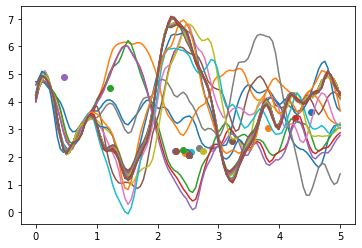

In [152]:
for i in range(len(res4.models)):
    X = np.linspace(0,5,100)
    plt.scatter(res4.x_iters[i],res4.func_vals[i])
    plt.plot(X,res4.models[i].sample_y(X.reshape(-1, 1)))
    
plt.show()

In [155]:
res4.models[3]

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.01, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=2012120129)

In [158]:
GPRlist = res4.copy()

In [191]:
GPR = GPRlist['models'][3]

In [192]:
s = GPR.fit(np.array(res4.x_iters[-1]).reshape(-1, 1),np.array(res4.func_vals[-1]).reshape(-1, 1))

In [193]:
y= GPR.predict(X.reshape(-1, 1),s)


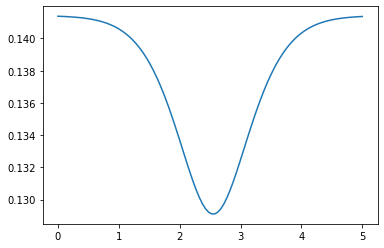

In [194]:
plt.plot(X,y[1])

In [167]:
res4.x_iters

[[4.518745607503323],
 [3.8148717328546784],
 [1.2150748090027665],
 [4.256029084457726],
 [0.45805959428081416],
 [3.224172734084765],
 [2.8936686223093417],
 [2.681827638448056],
 [2.7414721880929056],
 [2.555312027586277],
 [2.4795144692347955],
 [2.4490861253629093],
 [2.412320195657021],
 [2.512763010994642],
 [2.2902655999105197],
 [2.3095785347601288],
 [2.510943704625646],
 [2.511858315408034],
 [2.511703969414131],
 [2.5114272953032497],
 [2.511053942628067],
 [2.5105772801184774],
 [2.5103199303949224],
 [2.5098954024183144],
 [2.5097623849294286],
 [2.5088686509013627],
 [2.508586355740581],
 [2.507788226404335],
 [2.4598889164714928],
 [2.550990344395139]]

In [121]:
X = np.linspace(0.5,4,100)
len(res4.models)

21

In [125]:
res4copy = res4.copy()

In [103]:
res4.models[0].predict(np.linspace(0.5,4,100).reshape(-1, 1))

array([3.46304472e+09, 3.46402724e+09, 3.46539738e+09, 3.46689323e+09,
       3.46858235e+09, 3.47056066e+09, 3.47268571e+09, 3.47478094e+09,
       3.47678665e+09, 3.47870222e+09, 3.48046722e+09, 3.48200425e+09,
       3.48327494e+09, 3.48428139e+09, 3.48505147e+09, 3.48562444e+09,
       3.48604108e+09, 3.48633835e+09, 3.48654708e+09, 3.48669167e+09,
       3.48679067e+09, 3.48685776e+09, 3.48690283e+09, 3.48693288e+09,
       3.48695276e+09, 3.48696584e+09, 3.48697440e+09, 3.48697997e+09,
       3.48698358e+09, 3.48698591e+09, 3.48698740e+09, 3.48698836e+09,
       3.48698897e+09, 3.48698936e+09, 3.48698961e+09, 3.48698977e+09,
       3.48698986e+09, 3.48698993e+09, 3.48698997e+09, 3.48698999e+09,
       3.48699001e+09, 3.48699002e+09, 3.48699002e+09, 3.48699003e+09,
       3.48699003e+09, 3.48699003e+09, 3.48699003e+09, 3.48699003e+09,
       3.48699003e+09, 3.48699003e+09, 3.48699003e+09, 3.48699003e+09,
       3.48699003e+09, 3.48699003e+09, 3.48699003e+09, 3.48699003e+09,
      

In [83]:
res4.x

[2.2453794596974093]

In [64]:
from skopt.plots import plot_gaussian_process

In [138]:
newfun = lambda x : 2+0.1*(x-2)**2

C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


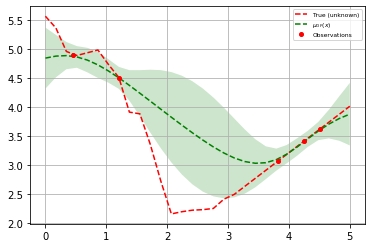

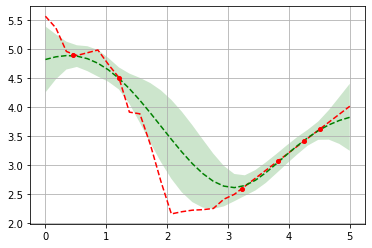

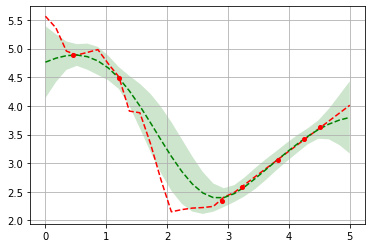

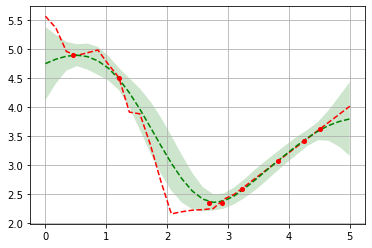

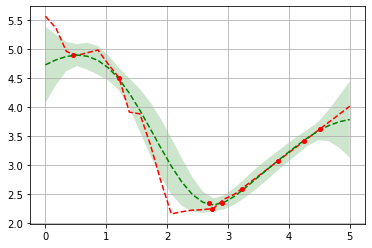

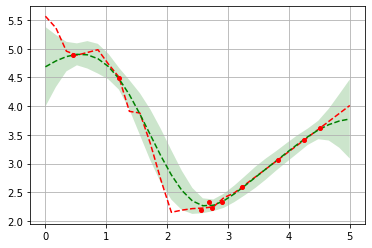

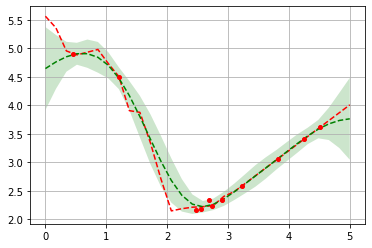

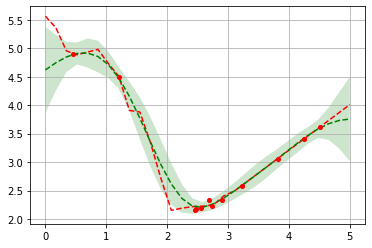

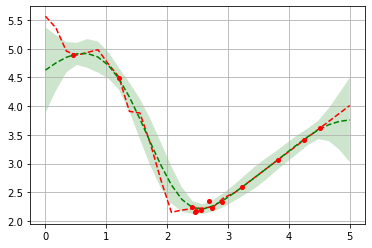

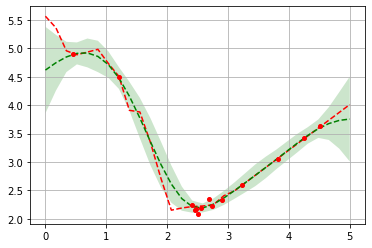

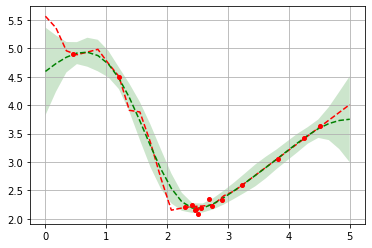

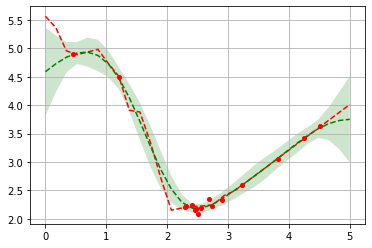

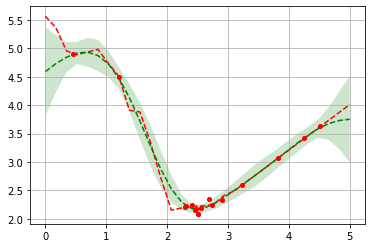

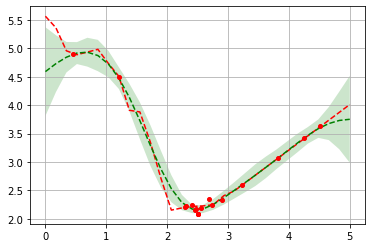

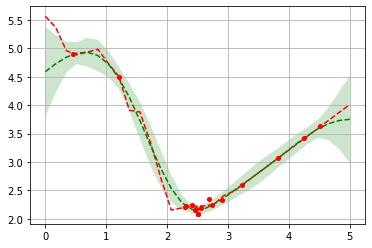

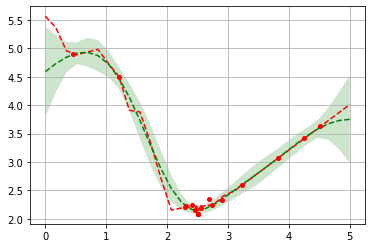

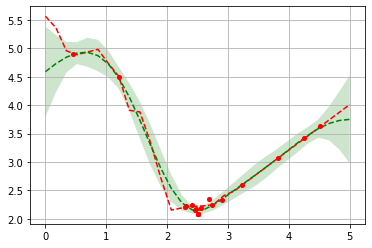

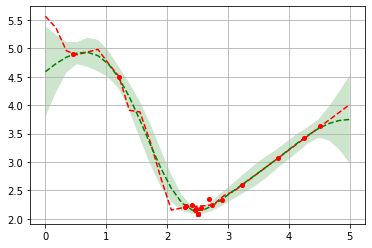

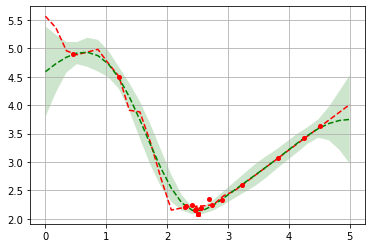

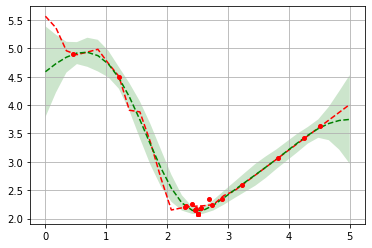

In [145]:
for n_iter in range(20):
    # Plot true function.
    #plt.subplot(5, 2, 2*n_iter+1)
    plt.figure()

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res4, n_calls=n_iter,
                               objective=obj4_inter,
                               noise_level=0,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False,
                               n_points=30)
    #ax.set_ylabel("")
    #ax.set_xlabel("")
    # Plot EI(x)
    #plt.subplot(5, 2, 2*n_iter+2)
    #plt.figure()
    #ax = plot_gaussian_process(res4, n_calls=n_iter,
    #                           show_legend=show_legend, show_title=False,
    #                           show_mu=False, show_acq_func=True,
    #                           show_observations=False,
    #                           show_next_point=True,
    #                           n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

# Random objective

In [7]:
from skopt import gp_minimize
from skopt.plots import plot_gaussian_process

In [26]:
res_r = gp_minimize(objective_r,     # the function to minimize
                  [(0.0, 5.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=200,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=2.0,       # the noise level (optional)
                  random_state=1234)   # the random seed

[2.4883183323632467]
655
2.0990833837177973
[4.089192205582848]
933
3.2801684271846323
[3.0605594733863546]
541
2.6139014971408243
[3.856799594312006]
189
3.1397636429382088
[4.303348856888437]
754
3.451955384306658
[2.315910671845743]
163
2.0306039892150554
[2.1444005216322677]
305
4.290529274745937
[2.335914272119974]
99
1.971132627338815
[2.3650355557211613]
848
2.0397206983829066
[2.390968354257011]
749
2.4132406118151546
[2.4070915840128593]
39
2.310450977432538
[2.4305394757280405]
881
2.1465040834262736
[2.455874094569233]
422
2.4006940360843196
[2.5031626688855324]
713
2.046753256792836
[2.538948365765152]
330
2.3158743456176616
[2.5669252439121157]
35
2.2167529610614394
[2.6073445350113]
254
2.1342852597113193
[2.648520115102686]
196
2.2202807723024263
[2.6850699141246697]
554
2.26244152806724
[2.721274496380368]
159
2.182885576408692
[2.7605498110938225]
841
2.2802207265823475
[2.79001134738031]
790
2.28618224069951
[2.8271113413765163]
100
2.318441151453581
[2.87151342774830

C:\Users\pdine\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


250
4.010778
[2.1052119479886673]
860
3.36264523857436
[3.112742790708713]
430
2.5668480873167705
[3.0442388510789318]
610
2.6121558429237655
[2.8592303696312973]
12
2.5186954969092485
[3.2477196266920987]
849
2.605176485780977
[2.691227719676541]
929
2.2489847115462274
[2.6975309466326114]
859
2.2109340463149434
[2.702288558580153]
429
2.5767067194722433
[3.2807439951083603]
730
2.6820116406199417
[2.57945803218853]
90
2.3817909447266463
[2.620234132543549]
656
2.1018354827309498
[2.649254376075747]
853
2.4968572331224013
[2.143379033170463]
173
2.0694236735291542
[2.1334843685966565]
202
2.325849249900082
[2.5120170055147155]
111
3.0574971282792403
[1.7841120068244751]
113
3.0851523119297535
[3.268530528508795]
175
2.6218700672142896
[2.7231087522782325]
338
2.26034155701167
[2.7198488124852336]
382
2.252072968862061
[2.715508840781063]
858
2.2548147118172888
[2.707827037846475]
708
2.3582367237898523
[3.309311624042561]
51
2.6545828513708343
[2.575671697877694]
842
2.082670381222933

C:\Users\pdine\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[5.0]
422
4.010778
[2.767486830598869]
717
2.2914822241079773
[2.753782610693318]
706
2.2774950287209235
[2.6273388172471037]
556
2.107534545352141
[2.6097144443986604]
215
2.108637775706573
[2.7856425566868124]
455
2.2883604768231782
[2.538744816383449]
21
2.505457262404607
[2.9122986274661047]
159
2.336116652894249
[2.51531077976337]
409
2.079587080385981
[2.5168926199924933]
660
2.01893950972565
[2.5183677817872625]
579
2.4363611803122294
[2.868530979452167]
157
2.4953726098215863
[2.4730479803901644]
569
2.489440365512581
[3.4897459460728593]
710
2.799319253219642
[2.823678990896594]
45
2.441674412287555
[2.448086698724408]
419
2.0459580504604657
[2.451313909296227]
53
2.327721999927216
[2.4564787093935814]
101
2.288291592651643
[2.8083182286585755]
468
2.4702841361508505
[2.4216859501596155]
641
2.139593065014895
[2.4261576012491526]
467
2.195108460913879
[2.43226559346241]
690
2.3790711431389977
[2.7936818707281046]
168
2.44971241793939
[2.3990998697935257]
955
2.211285240506906


In [23]:
all_walls_array = np.load('all_walls_array.npy')
h = []
fh = []
for row in all_walls_array:
    if np.array_equal(row[:2],np.array([0.,163.])):
        h.append(row[2])
        fh.append(row[3]/1e9)
def f_wo_noise(x):
    return np.interp(x, h, fh)

In [24]:
f_wo_noise(0.3)

5.552569356464525

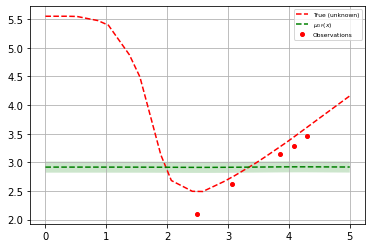

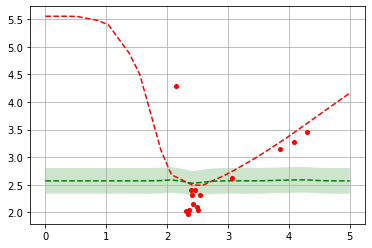

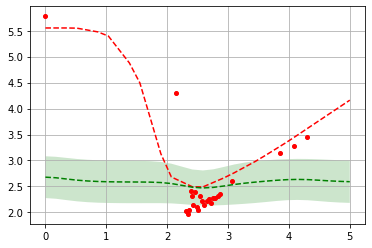

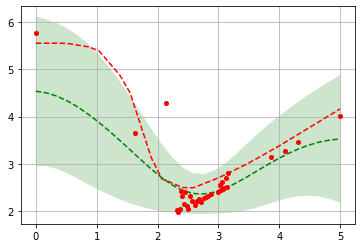

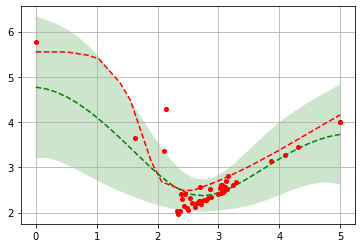

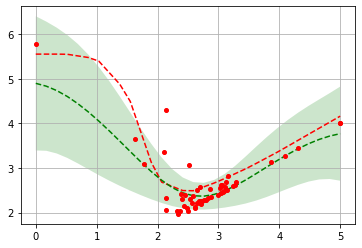

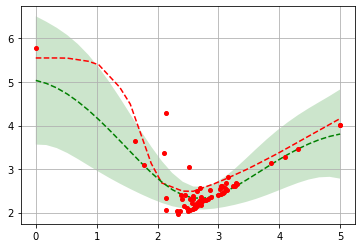

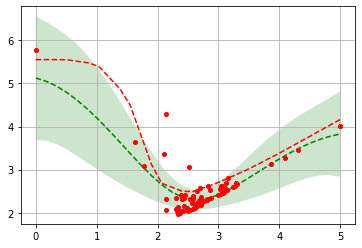

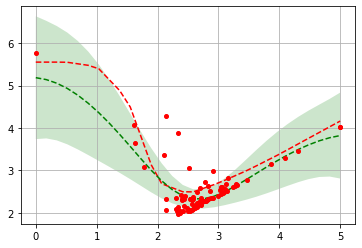

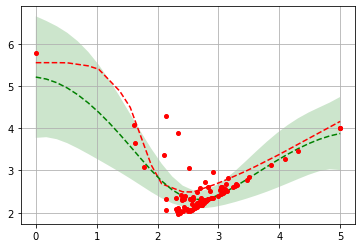

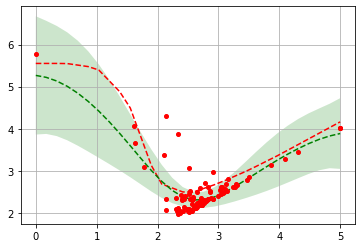

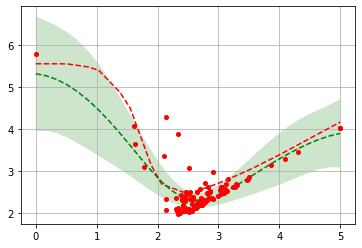

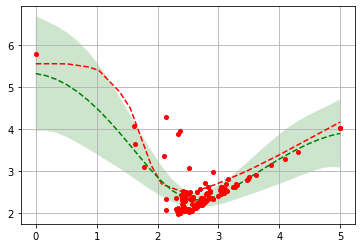

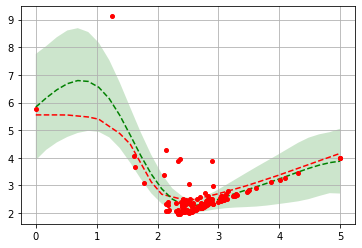

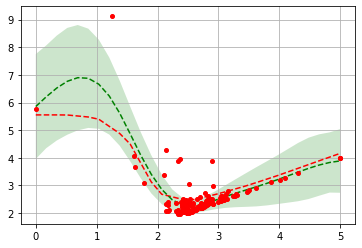

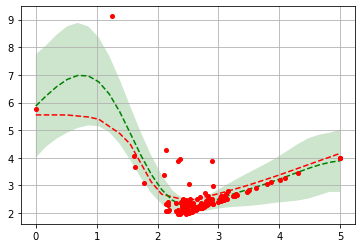

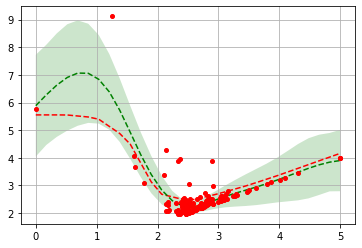

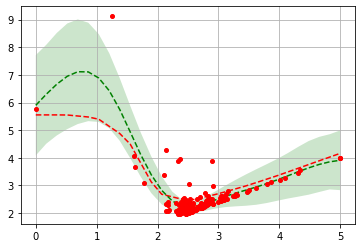

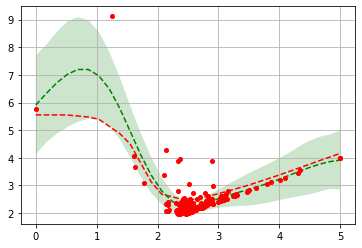

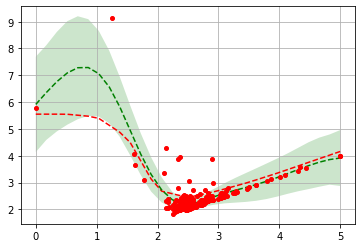

In [29]:
for n_iter in range(0,200,10):
    # Plot true function.
    #plt.subplot(5, 2, 2*n_iter+1)
    plt.figure()

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res_r, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=0,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False,
                               n_points=30)
    #ax.set_ylabel("")
    #ax.set_xlabel("")
    # Plot EI(x)
    #plt.subplot(5, 2, 2*n_iter+2)
    #plt.figure()
    #ax = plot_gaussian_process(res4, n_calls=n_iter,
    #                           show_legend=show_legend, show_title=False,
    #                           show_mu=False, show_acq_func=True,
    #                           show_observations=False,
    #                           show_next_point=True,
    #                           n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

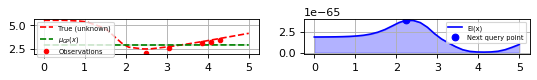

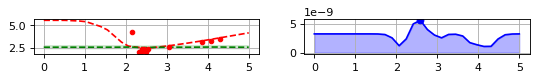

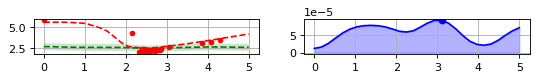

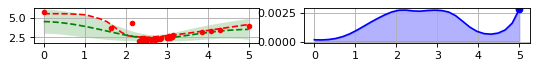

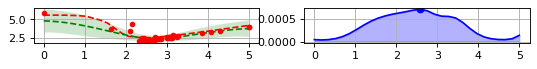

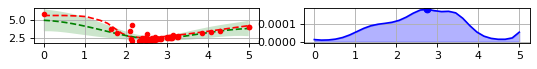

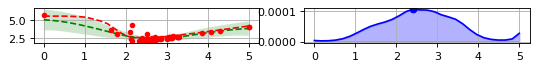

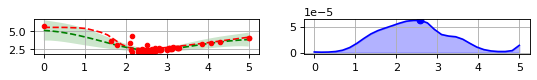

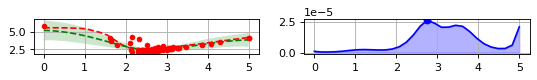

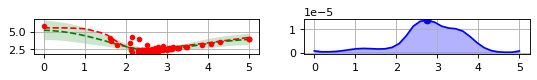

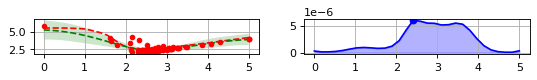

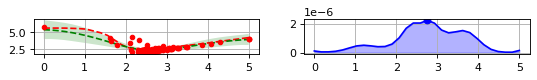

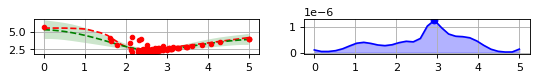

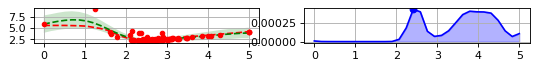

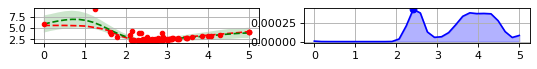

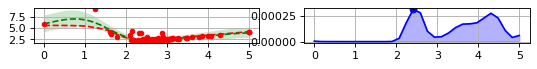

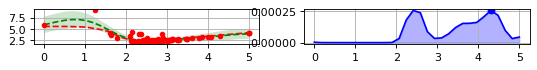

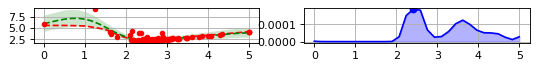

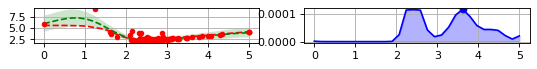

In [48]:

for i, n_iter in enumerate(range(0,190,10)):
    plt.figure(figsize=(8, 14), dpi=80)
    # Plot true function.
    plt.subplot(20, 2, 2*i+1)
    #plt.figure()

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res_r, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=0,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False,
                               n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")
    #Plot EI(x)
    plt.subplot(20, 2, 2*i+2)
    #plt.figure()
    ax = plot_gaussian_process(res_r, n_calls=n_iter,
                              show_legend=show_legend, show_title=False,
                              show_mu=False, show_acq_func=True,
                              show_observations=False,
                              show_next_point=True,
                              n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

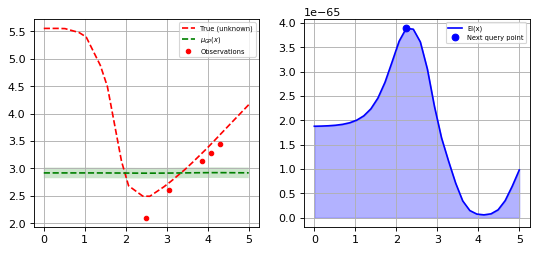

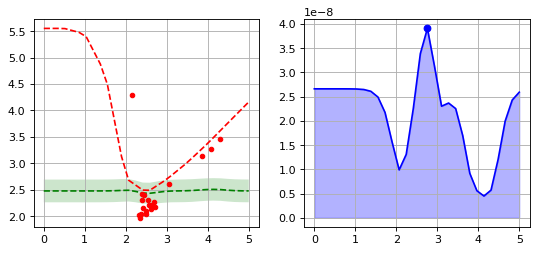

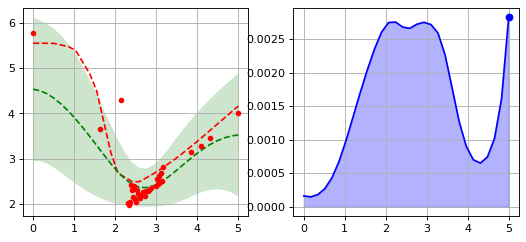

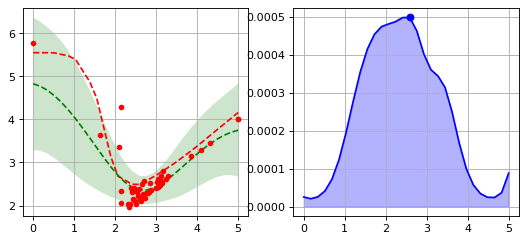

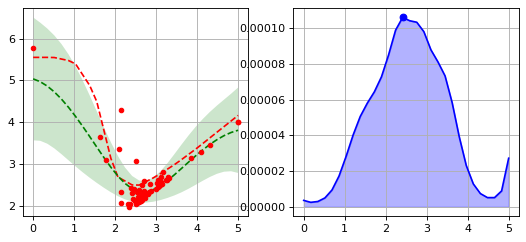

In [89]:
plotrange = range(0,61,15)
for i, n_iter in enumerate(plotrange):
    plt.figure(figsize=(8, 20), dpi=80)
    # Plot true function.
    plt.subplot(len(plotrange), 2, 2*i+1)
    #plt.figure()

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res_r, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=0,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False,
                               n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")
    #Plot EI(x)
    plt.subplot(len(plotrange), 2, 2*i+2)
    #plt.figure()
    ax = plot_gaussian_process(res_r, n_calls=n_iter,
                              show_legend=show_legend, show_title=False,
                              show_mu=False, show_acq_func=True,
                              show_observations=False,
                              show_next_point=True,
                              n_points=30)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

In [32]:
res_r.x

[2.182646697752937]

In [ ]:
# I think you might have some surgeGeo stuff in there :/ redo with correct thing

In [75]:
res4.x

[2.0804645401605466]

In [13]:
objective2([1,1,1,1,1,1,1,1,1])

0
4836656042.531507


4836656042.531507

In [17]:
objective3([85,15,3.15])

[85, 15, 3.15]
0


5565069925.69983

In [240]:
X_train = res2.x_iters.copy()

In [241]:
y_train = res2.func_vals.copy()

In [205]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

3.53**2 * RBF(length_scale=1.42)

In [220]:
x_opt = (res2.x).copy()
print(x_opt)
print(res2.fun)

[3.2687253766155515, 1.8039208442832713, 2.9035802422449515, 1.6200833446016525, 1.4627162361677573, 1.3080887633766016, 5.0, 1.0524189281894356]
1.60660741803422


In [222]:
x_opt

[3.2687253766155515,
 1.8039208442832713,
 2.9035802422449515,
 1.6200833446016525,
 1.4627162361677573,
 1.3080887633766016,
 5.0,
 1.0524189281894356]

C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


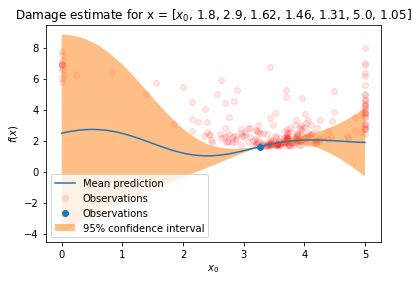

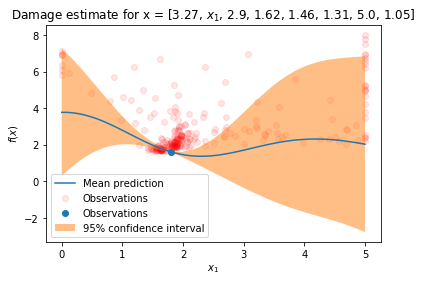

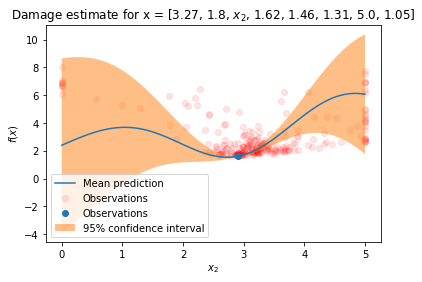

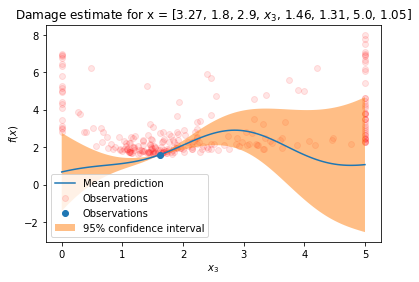

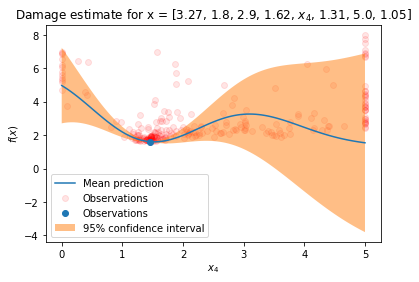

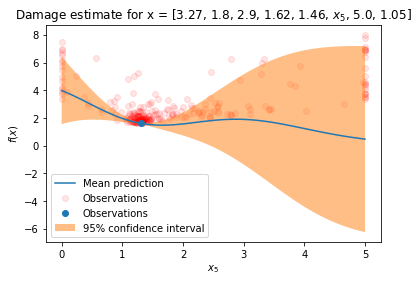

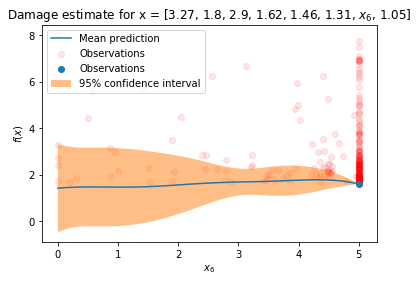

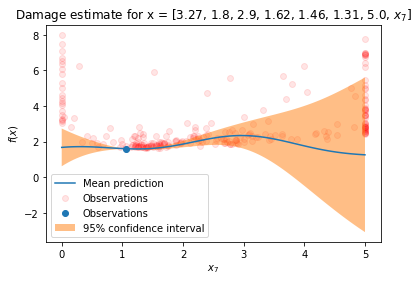

In [263]:
for change_index in range(8):
    plt.figure()
    X_to_pred = np.zeros((101,8))
    for i, x in enumerate(np.linspace(0,5.0,101)):
        X_to_pred[i,:] = x_opt.copy()
        X_to_pred[i,change_index] = x


    mean_prediction, std_prediction = gaussian_process.predict(X_to_pred, return_std=True)


    all_X = np.array(X_train)
    all_y = np.array(y_train)

    #plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
    plt.scatter(all_X[:,change_index], all_y, label="Observations",color = 'red',alpha = 0.1)
    plt.scatter(x_opt[change_index], res2.fun, label="Observations")
    plt.plot(np.linspace(0,5.0,101), mean_prediction, label="Mean prediction")
    plt.fill_between(
        X_to_pred[:,change_index].ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    plt.xlabel("$x_" +str(change_index)+"$")
    plt.ylabel("$f(x)$")
    
    title = '['
    for j in range(8):
        if j == change_index:
            title = title + '$x_'+str(j)+'$'
        else:
            title = title + str(np.around(x_opt[j],decimals = 2))
        if j < 7:
            title = title + ', '
    title = title +']'
    plt.title("Damage estimate for x = "+title)
plt.show()

In [254]:
np.round(np.array(x_opt)*1000)/1000

array([3.269, 1.804, 2.904, 1.62 , 1.463, 1.308, 5.   , 1.052])

In [238]:
str(np.array([2.3,2,4]))[9:11]

'4.'

In [265]:
for i in range(3):
    objective2([0.2]*8)

0
5.317234976466337
0
5.317234976466337
0
5.317234976466337


In [10]:
hs = np.linspace(0.0,5.0,11)
dc_array = np.zeros((len(hs),len(hs)))
wc_array = np.zeros((len(hs),len(hs)))
ds_list = []
for i, h_0 in enumerate(hs):
    for j, h_1 in enumerate(hs):
        h_array = np.array([3.269, 1.804, 2.904, 1.62 , 1.463, 1.308, 5.   , 1.052])
        h_array[0] = h_0
        h_array[1] = h_1
        dc, wc, ds = damage2(h_array)
        dc_array[i,j] = dc
        wc_array[i,j] = wc
        ds_list.append(ds)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


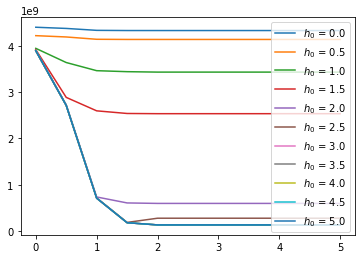

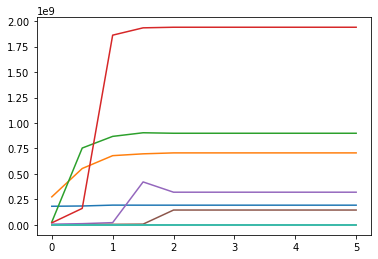

In [16]:
for i, h_0 in enumerate(hs):
    plt.plot(hs,dc_array[i,:],label = '$h_0$ = ' + str(h_0))
plt.legend()


plt.figure()
for i, h_0 in enumerate(hs):
    if i > 0:
        plt.plot(hs,dc_array[i-1,:]-dc_array[i,:],label = '$f('+str(hs[i-1])+',\\cdot) - f('+str(hs[i])+',\\cdot)$')
#plt.legend()

plt.show()

In [19]:
ds_list_np = np.array(ds_list)
print(ds_list_np.shape)

(121, 1, 18, 1)


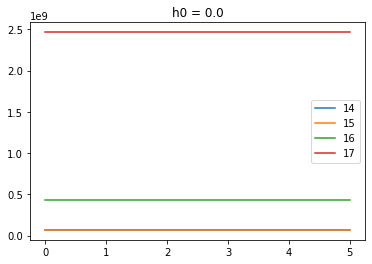

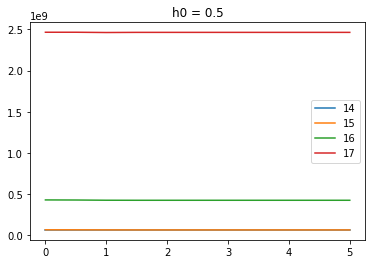

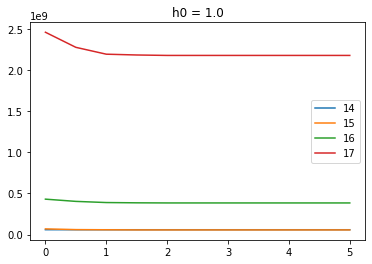

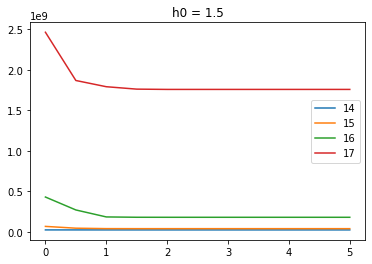

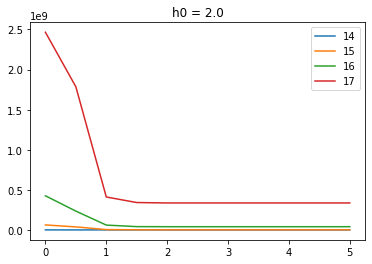

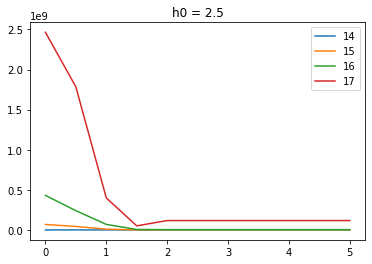

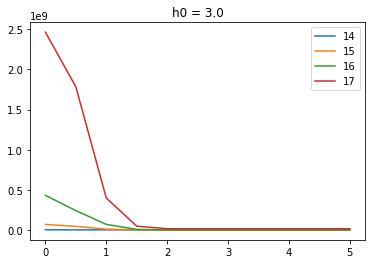

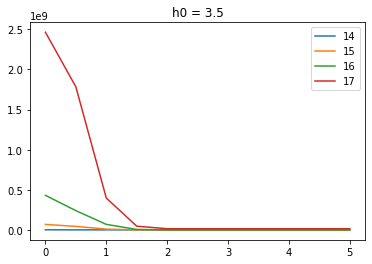

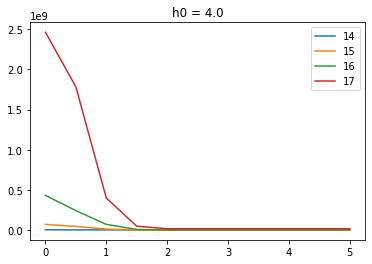

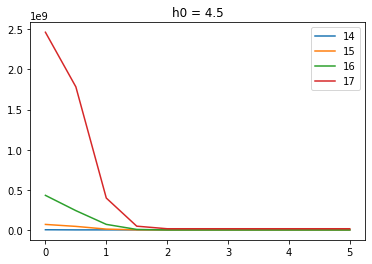

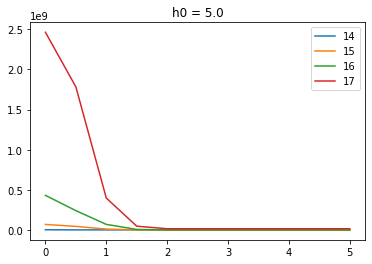

In [29]:
for i, h_0 in enumerate(hs):
    plt.figure()
    for div in range(14,18):
        plt.plot(hs,ds_list_np[(11*i):(11*i+11),0,div,0], label = str(div))
        plt.legend()
        plt.title('h0 = '+str(h_0))
plt.show()

In [31]:
ds_array = np.zeros((len(hs),len(hs),18))
for i in range(len(hs)):
    for j in range(len(hs)):
        ds_array[i,j,:] = ds_list_np[11*i+j,0,:,0] 

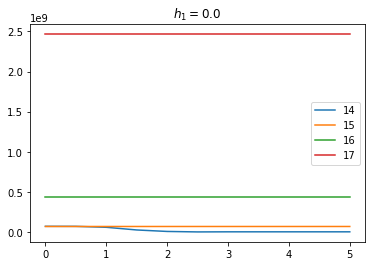

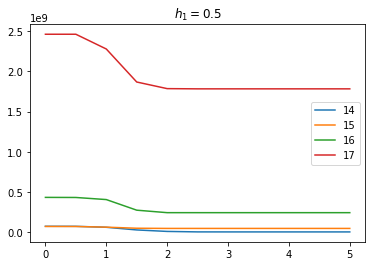

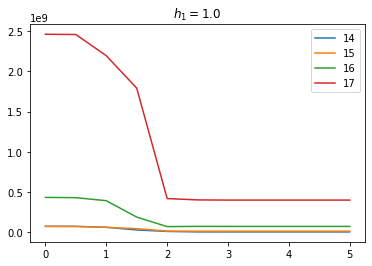

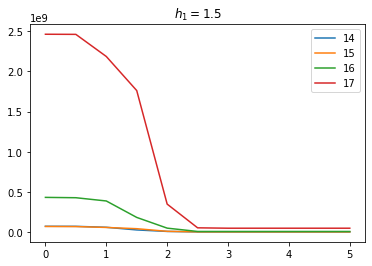

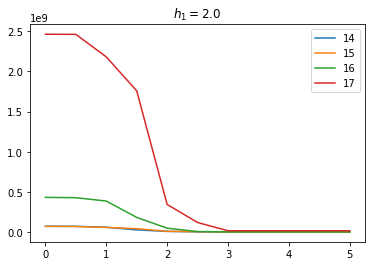

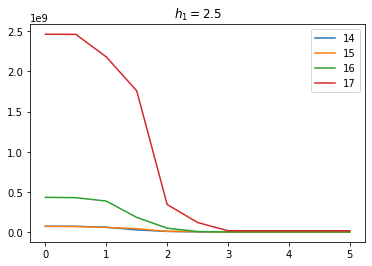

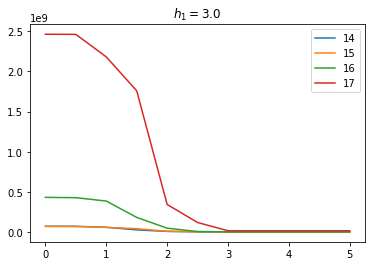

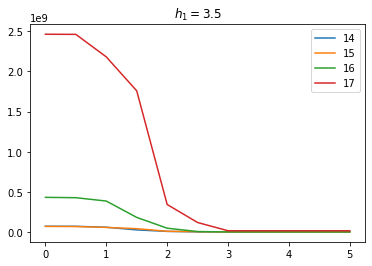

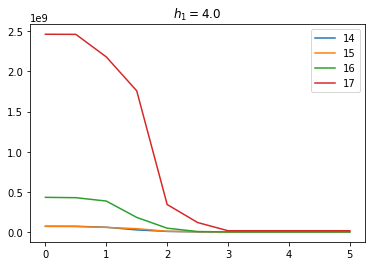

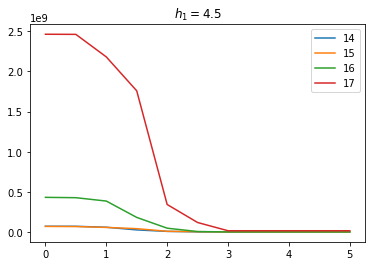

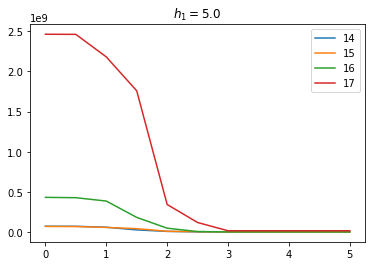

In [37]:
for j, h_1 in enumerate(hs):
    plt.figure()
    for div in range(14,18):
        plt.plot(hs,ds_array[:,j,div], label = str(div))
        plt.legend()
        plt.title('$h_1 = '+str(h_1)+'$')
plt.show()

# 8 wall opt bayes

use vizualizations
https://scikit-optimize.github.io/stable/modules/plots.html

In [73]:
def objective8r(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    #num_iter = np.random.randint(10)
    num_iter = 50
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective_random_storms(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=num_iter)
    #print(total_cost_new/1e9)
    return total_cost_new/1e9

In [74]:
res8r_new = gp_minimize(objective8r,     # the function to minimize
                  [(0.0, 5.0)]*8,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  noise=0.01,       # the noise level (optional)
                  random_state=1234)   # the random seed

782
18
593
424
842
770
787
66
730
91
121
697
776
515
949
116
186
223
612
749
256
100
823
674
107
831
901
37
243
6
108
244
335
453
849
59
567
926
546
440
981
918
649
567
126
496
508
866
597
722
626
140
414
116
703
886
214
450
295
993
343
883
307
309
932
810
494
138
844
312
161
859
782
202
837
60
926
244
9
187
345
277
60
270
499
842
399
324
862
876
88
566
128
838
34
883
321
410
701
233
269
41
93
872
280
148
618
102
139
411
499
477
756
68
298
338
703
220
468
637
494
425
324
570
870
891
598
763
15
996
2
989
924
582
65
473
247
406
965
63
771
175
201
10
677
365
290
788
233
669
316
497
888
15
497
40
634
133
934
151
788
473
355
137
315
589
553
437
583
258
316
168
604
651
938
994
62
30
200
905
561
782
789
649
627
92
24
117
784
494
522
387
358
189
107
781
838
770
836
429
383
121
859
513
249
310
855
351
857
511
236
563
225
474
835
42
275
361
887
157
932
867
393
366
102
883
638
904
400
537
478
91
77
868
7
862
715
80
186
655
682
973
658
559
188
293
548
103
718
541
393
913
987
485
708
51
297
684
222

93
728
138
27
598
20
869
247
536
571
104
250
989
734
139
161
765
413
585
405
199
4
444
959
250
117
683
845
613
805
559
942
438
861
131
192
774
192
972
955
619
520
813
189
346
542
366
22
664
398
271
784
287
398
783
744
728
549
817
973
373
755
299
424
714
552
610
209
537
779
182
266
522
731
544
527
597
792
743
112
255
408
926
886
5
667
112
817
368
843
313
289
403
249
381
479
446
89
443
906
280
547
814
905
802
353
417
998
354
309
830
911
686
871
176
32
490
999
22
64
607
289
945
97
823
550
831
150
487
805
36
506
425
714
223
149
886
863
2
266
527
894
379
981
66
926
130
325
940
461
474
458
866
463
987
507
299
321
20
202
423
724
723
919
756
381
274
707
432
913
765
336
511
746
349
940
303
948
222
312
405
577
285
842
375
565
606
983
499
164
362
798
196
842
31
122
369
828
448
612
158
774
321
322
872
168
996
885
5
209
602
676
857
955
682
804
581
205
325
970
258
701
308
503
424
949
303
466
607
9
585
55
991
734
70
988
920
189
195
617
439
701
894
77
630
41
927
795
419
930
582
270
411
139
26
844
553


In [75]:
print(res8r_new.x)
print(res8r_new.fun)

[2.4042126739702208, 2.3565100228175635, 4.501075010528714, 3.3812992539903304, 1.8427614401051529, 1.6652348878584669, 0.0, 1.6236098360177833]
2.2722644388973525


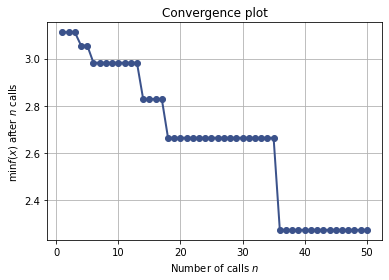

In [83]:
skopt.plots.plot_convergence(res8r_new)
plt.savefig('res8r_new_convergence.svg', format='svg', dpi=1200)

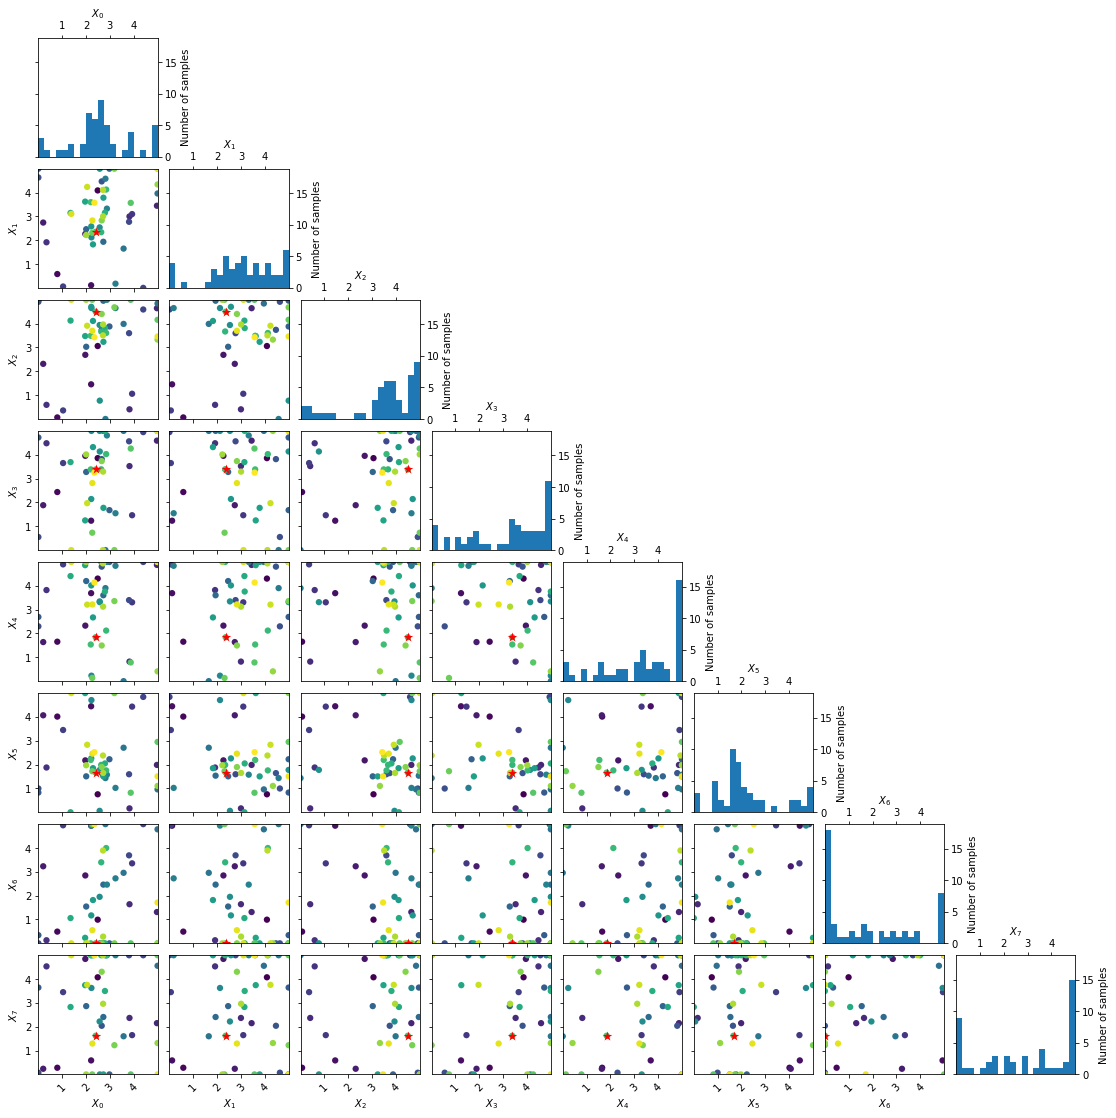

In [84]:
skopt.plots.plot_evaluations(res8r_new)
plt.savefig('res8r_new_plot_evaluations.svg', format='svg', dpi=1200)

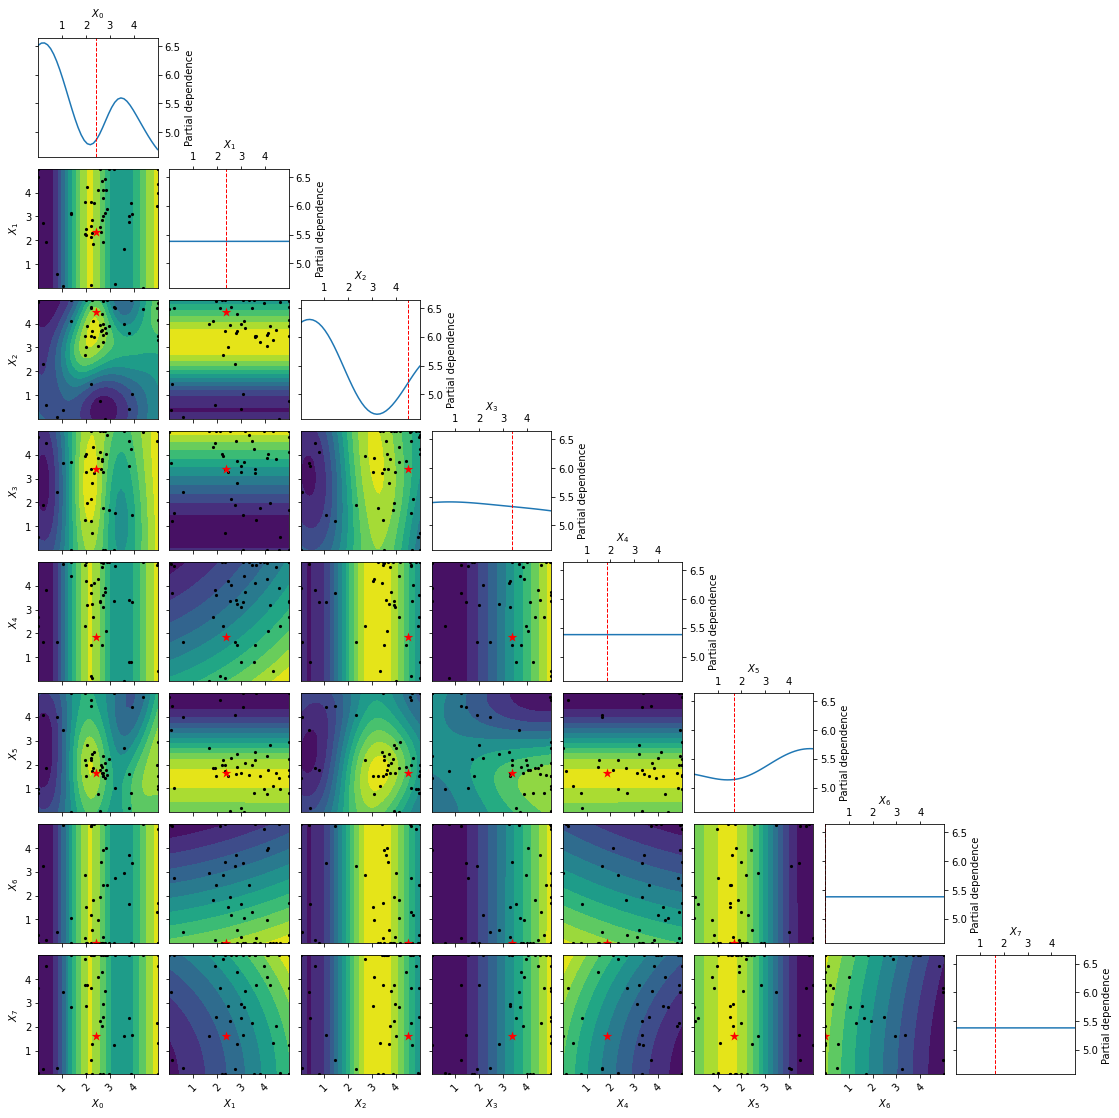

In [85]:
skopt.plots.plot_objective(res8r_new)
plt.savefig('res8r_new_plot_objective.svg', format='svg', dpi=1200)

0

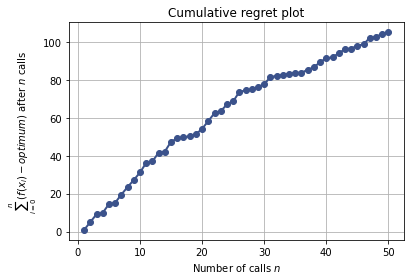

In [79]:
skopt.plots.plot_regret(res8r_new)
0

## old -----------

In [63]:
#res8r_old = res8r

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

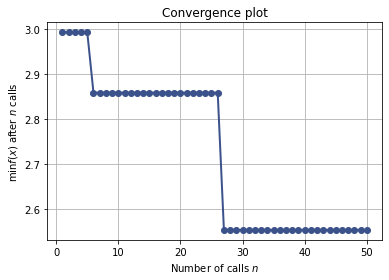

In [56]:
skopt.plots.plot_convergence(res8r)

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{2}$'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{3}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{3}$', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{4}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{4}$', ylabel='Numbe

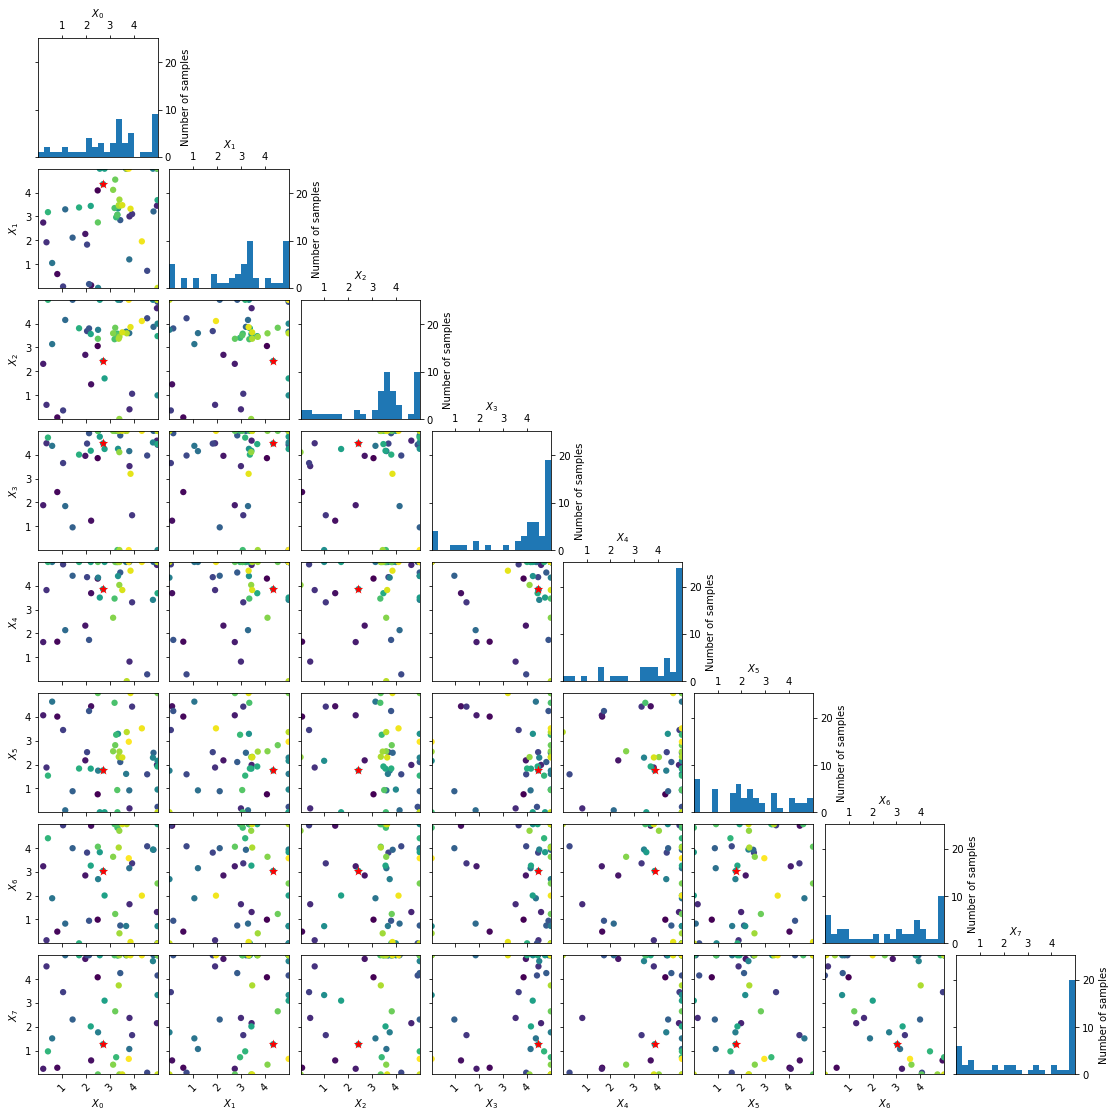

In [57]:
skopt.plots.plot_evaluations(res8r)

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{2}$'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{3}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{3}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{4}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{4}$', ylabel='P

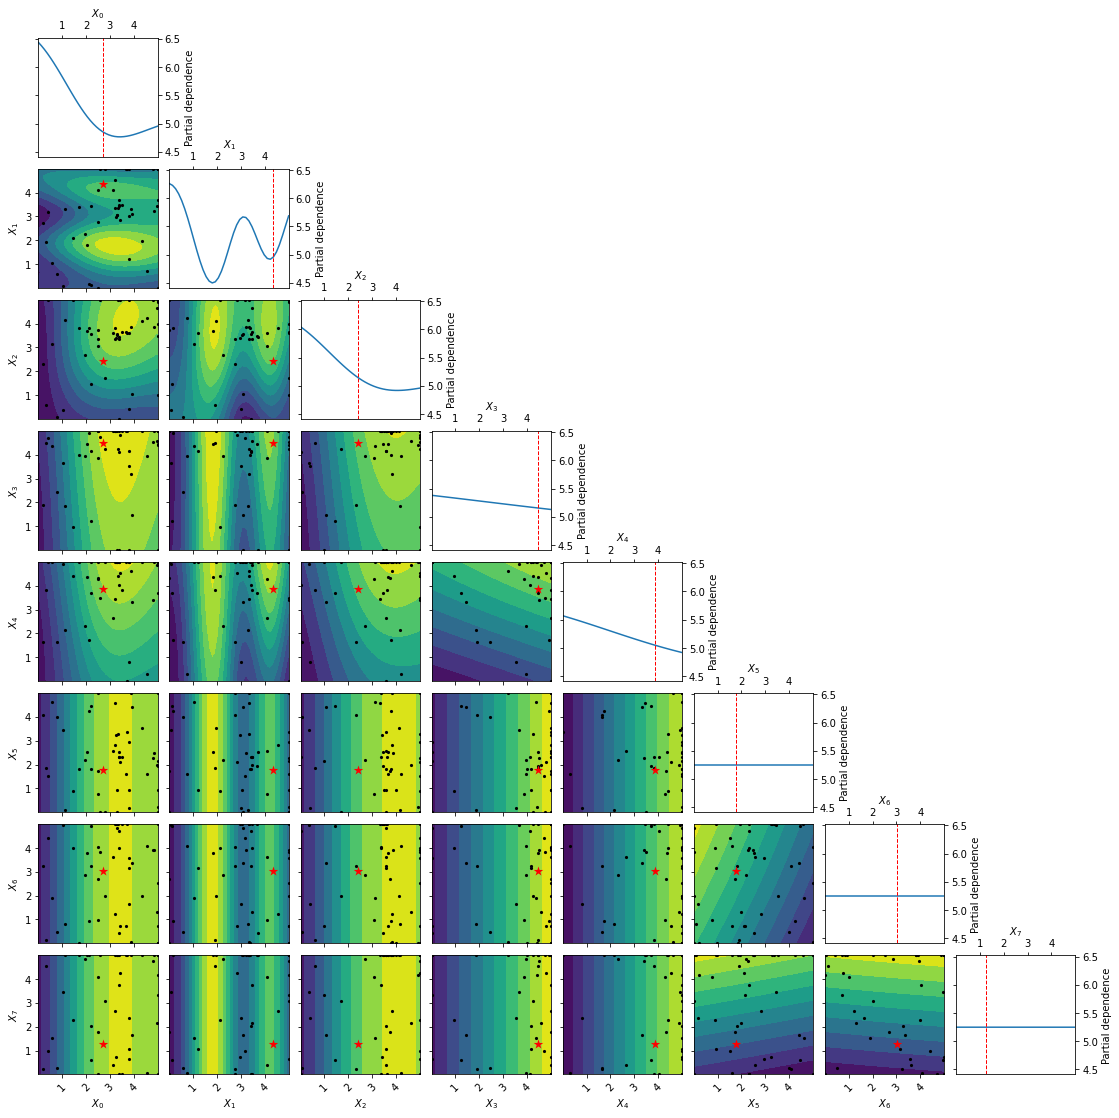

In [58]:
skopt.plots.plot_objective(res8r)

<AxesSubplot:title={'center':'Cumulative regret plot'}, xlabel='Number of calls $n$', ylabel='$\\sum_{i=0}^n(f(x_i) - optimum)$ after $n$ calls'>

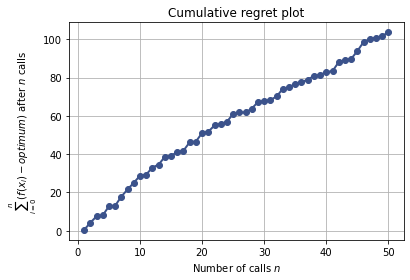

In [59]:
skopt.plots.plot_regret(res8r)

In [61]:
print(res8r.x)
print(res8r.fun)

[2.7160262125766583, 4.351269630126634, 2.430595104037087, 4.475245157642087, 3.8586888184293002, 1.7553144727634398, 3.0366120648503663, 1.2653153592833672]
2.5534933783588842


# No Noise

In [8]:
def objective100(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=100)
    print(total_cost_new/1e9)
    return total_cost_new/1e9

In [9]:
res100 = gp_minimize(objective100,     # the function to minimize
                  [(0.0, 5.0)]*8,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=200,         # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  noise=0.0,       # the noise level (optional)
                  random_state=1234)   # the random seed

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
3.2334876182763015
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
6.482778308207235
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
6.369825657119112
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
2

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
5.150148211054433
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
4.859168743119024
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
3.1805861902705814
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
7.397546982279025
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.8499988895571238
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
3.367920806391057
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.6551190439043166
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
4.379461993474681
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.471775510275917
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.6435972

33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
7.834536050766723
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.0782224308391006
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
4.176803645668483
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


91
92
93
94
95
96
97
98
99
3.615367483321891
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.4614480358327713
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.0797312220156425
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.3784923305629158
0
1
2
3
4
5
6
7
8
9
10
11
12

48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
4.202253652654272
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.3736790803076526
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
5.125549309992765
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.0031192688584536
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
6.820430736243005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.7951163562265937
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
2

In [10]:
res100.x

[2.5295297113819486,
 1.5962946071932016,
 2.6317948703654137,
 1.3002937781952912,
 1.805670001256547,
 2.083296635105481,
 3.2295732822279133,
 2.035672604731452]

In [12]:
res100.fun

1.9891403630982885

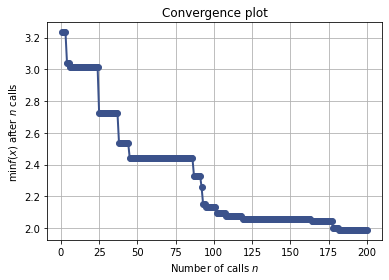

In [16]:
skopt.plots.plot_convergence(res100)
plt.savefig('bayes100convergence.svg', format = 'svg')

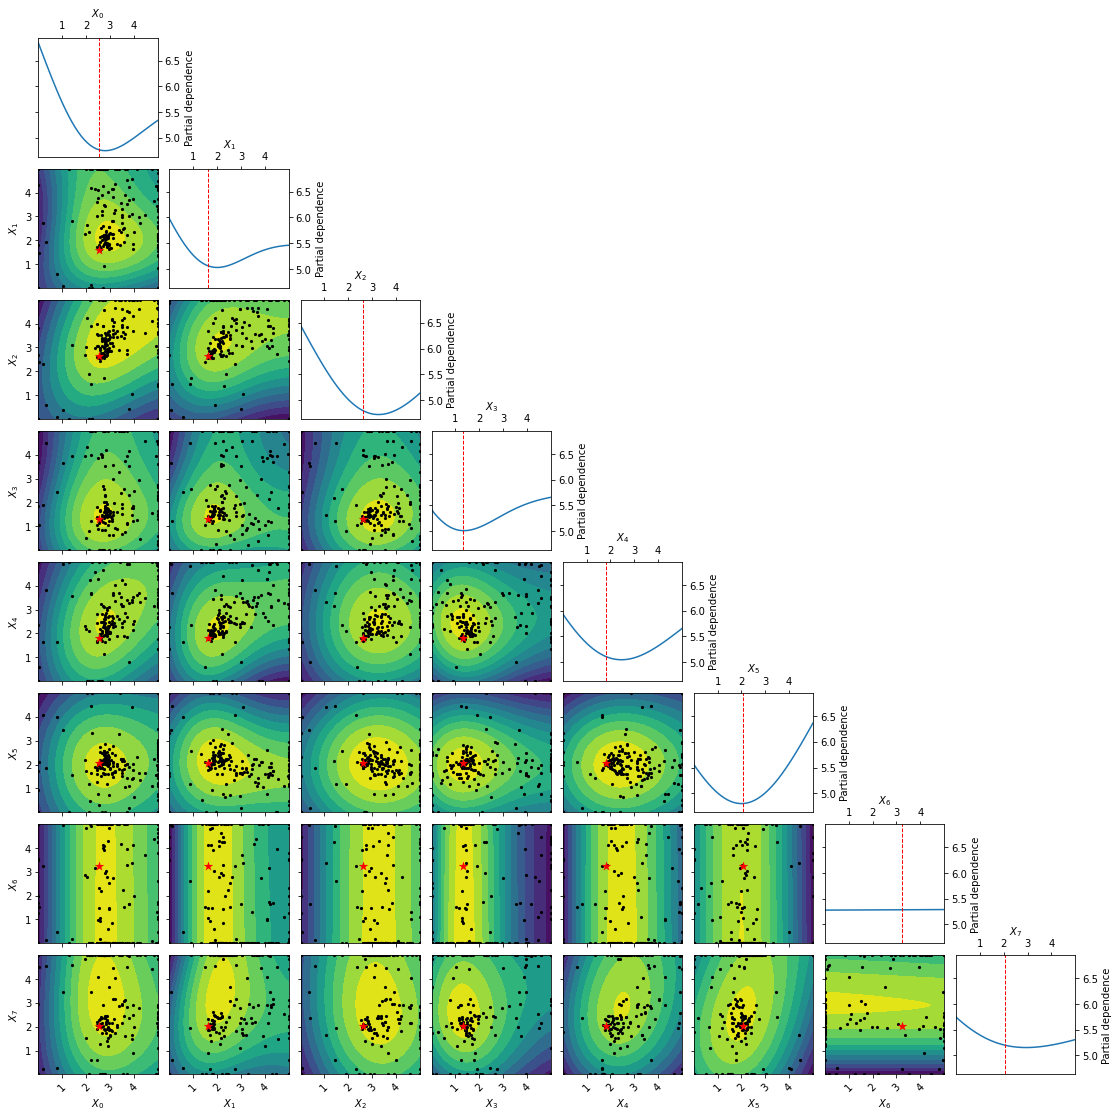

In [17]:
skopt.plots.plot_objective(res100)
plt.savefig('bayes100objective.svg', format = 'svg')

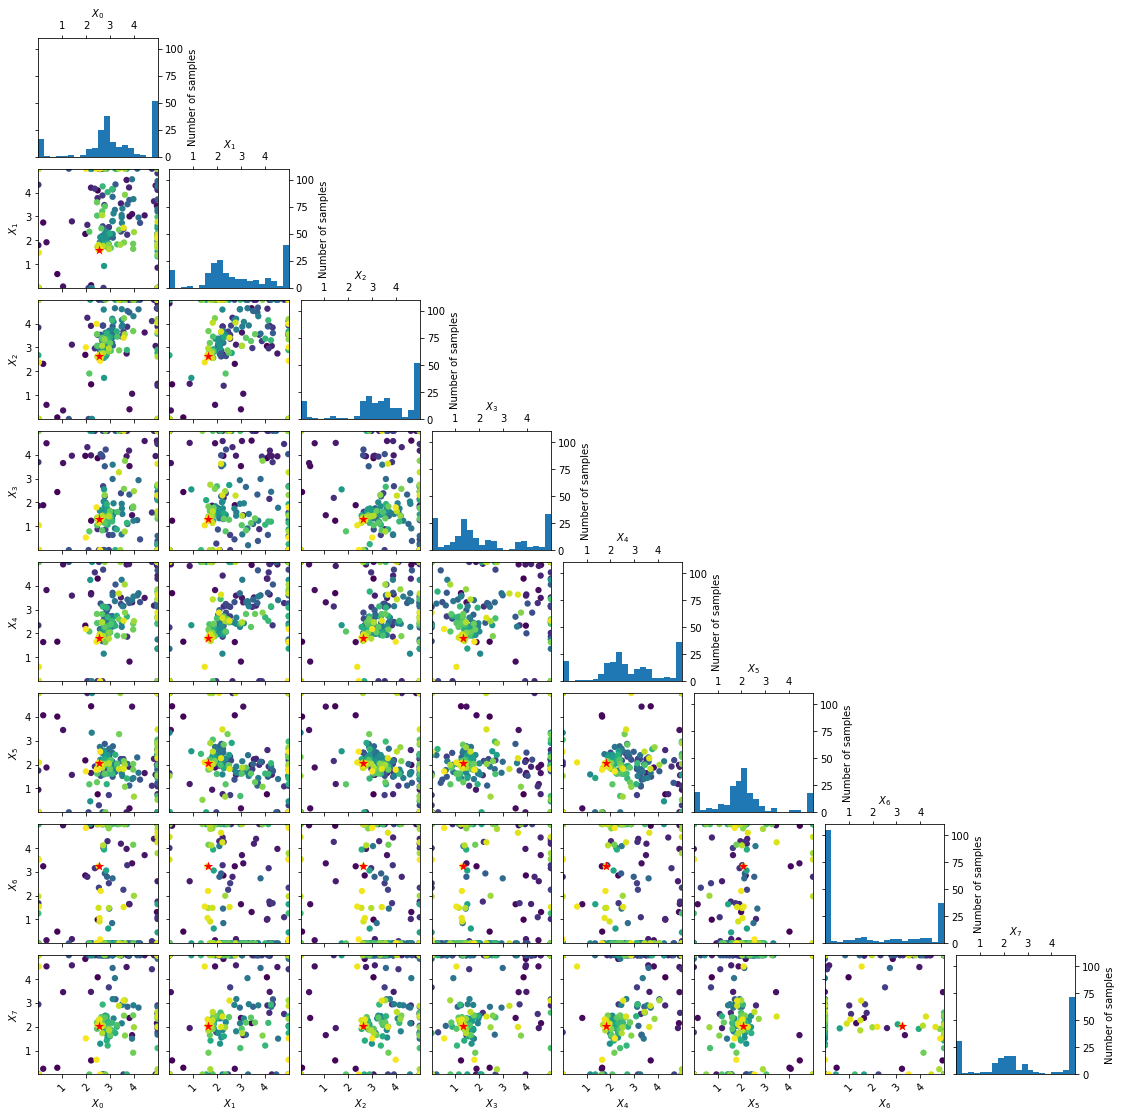

In [18]:
skopt.plots.plot_evaluations(res100)
plt.savefig('bayes100evals.svg', format = 'svg')

In [19]:
def objective100_full(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=100)
    #print(total_cost_new/1e9)
    return total_cost_new, wall_cost, n_cost_direct_sum_div

In [20]:
total_cost_new100b, wall_cost100b, n_cost_direct_sum_div100b = objective100_full(res100.x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [69]:
print(total_cost_new100b, wall_cost100b)

1989140363.0982885 1611318962.6235988


In [21]:
wall_cost100b

1611318962.6235988

In [45]:
wall_cost100b

1611318962.6235988

In [52]:
np.sum(np.array(n_cost_direct_sum_div100b)<0.5e9, axis = 0)

array([[100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [ 98],
       [100],
       [100],
       [100],
       [100],
       [ 98]])

# compare to div stuff

In [32]:
all_walls_array = np.load('all_walls_array.npy')
all_walls_div_array = np.load('all_walls_div_array.npy')
print(all_walls_array.shape)
print('start, end, height, total cost, wall cost')
print(all_walls_div_array.shape)

(1520, 5)
start, end, height, total cost, wall cost
(1520, 100, 18)


In [67]:
total_cost_new25, wall_cost25, n_cost_direct_sum_div25 = objective100_full(2.5*np.ones(8))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [68]:
print(total_cost_new25, wall_cost25,total_cost_new25-wall_cost25)

2278191062.892527 2005389000.0 272802062.8925271


In [60]:
print(total_cost_new25, wall_cost25,total_cost_new25-wall_cost25)

2278191062.892527 2005389000.0 272802062.8925271


In [56]:
print(np.sum(np.array(n_cost_direct_sum_div25)<threshold, axis = 0))

[[100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [100]
 [ 99]]


[0.00000000e+00 1.63000000e+02 2.50000000e+00 2.44728282e+09
 1.99308600e+09]
[100 100 100 100 100 100 100 100 100 100 100 100  99 100 100 100 100  99]


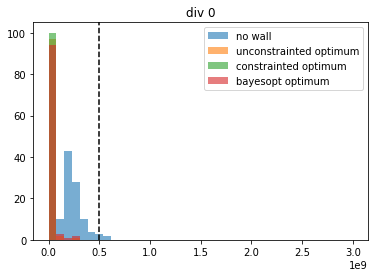

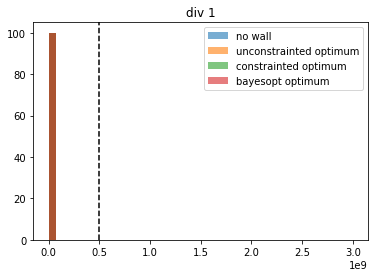

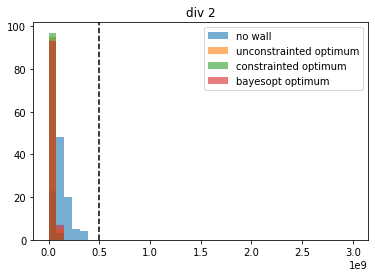

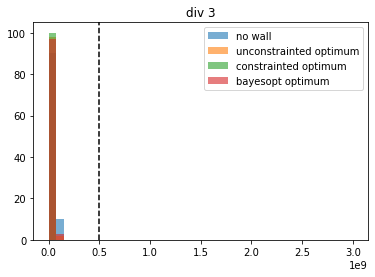

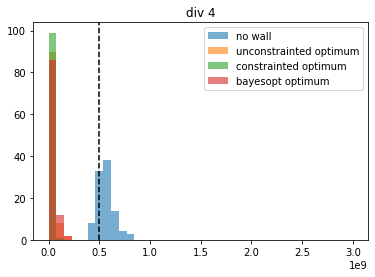

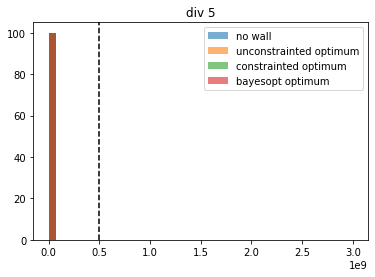

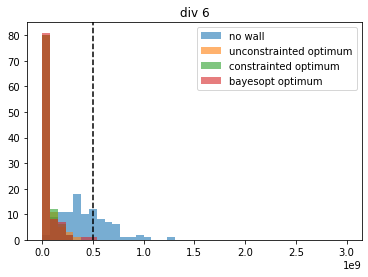

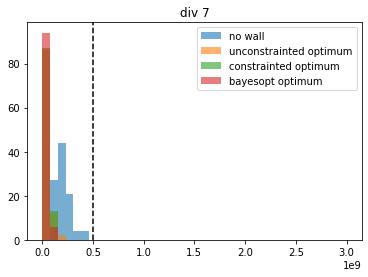

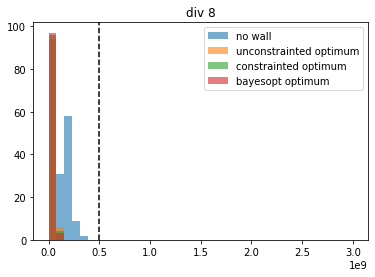

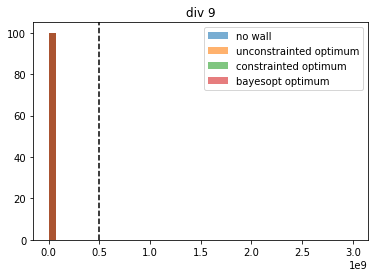

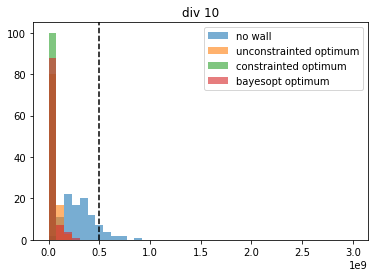

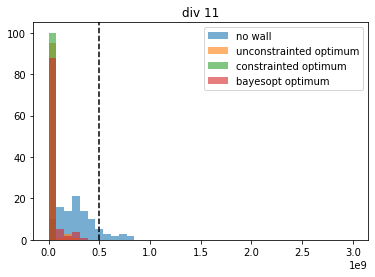

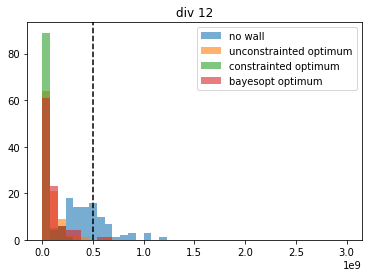

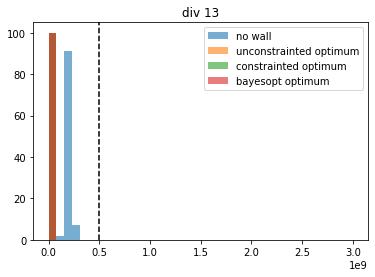

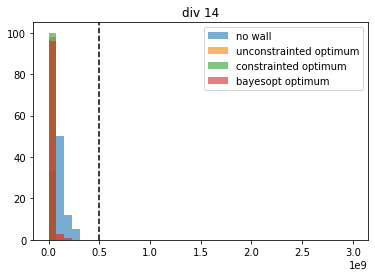

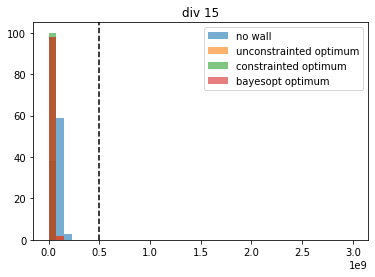

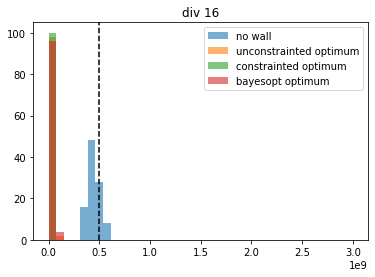

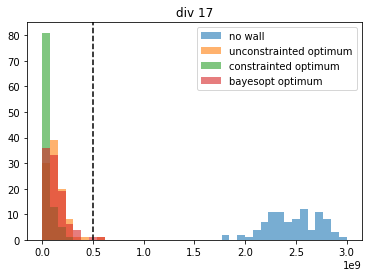

In [63]:
bins = np.linspace(0,3e9,40)
wallid = 164
print(all_walls_array[wallid])


threshold = 5e8
print(np.sum(all_walls_div_array[wallid,:,:]<threshold, axis = 0))

for i in range(18):
    plt.hist(all_walls_div_array[0,:,i], bins = bins,alpha = 0.6, label = 'no wall')
    plt.hist(all_walls_div_array[wallid,:,i], bins = bins, alpha = 0.6, label = 'unconstrainted optimum')
    plt.hist(all_walls_div_array[166,:,i], bins = bins,alpha = 0.6, label = 'constrainted optimum')
    plt.hist(np.array(n_cost_direct_sum_div100b)[:,i], bins = bins,alpha = 0.6, label = 'bayesopt optimum')
    n_cost_direct_sum_div100b
    plt.axvline(threshold, c = 'k', ls = '--')
    plt.title('div ' + str(i))
    plt.legend()
    plt.show()

In [64]:
2.44728282-1.99308600

0.45419681999999995